# Input Driven Observations ("GLM-HMM")

for $c \neq C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{\exp\{w_{kc}^\mathsf{T} u_t\}}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}}
\end{align}
$$

and for $c = C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{1}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}}
\end{align}
$$

where $c \in \{1, ..., C\}$ indicates the categorical class for the observation, $u_{t} \in \mathbb{R}^{M}$ is the set of input covariates, and $w_{kc} \in \mathbb{R}^{M}$ is the set of input weights associated with state $k$ and class $c$. These weights, along with the transition matrix and initial state probabilities, will be learned.

In Ashwood et al. (2020), $C = 2$ as $y_{t}$ represents the binary choice made by an animal during a 2AFC (2-Alternative Forced Choice) task. The above equations then reduce to:

$$
\begin{align}
\Pr(y_t = 0 \mid z_{t} = k, u_t, w_{k}) = 
\frac{\exp\{w_{k}^\mathsf{T} u_t\}}
{1 + \exp\{w_{k}^\mathsf{T} u_t\}} = \frac{1}
{1 + \exp\{-w_{k}^\mathsf{T} u_t\}}.
\end{align}
$$

$$
\begin{align}
\Pr(y_t = 1 \mid z_{t} = k, u_t, w_{k}) = 
\frac{1}
{1 + \exp\{w_{k}^\mathsf{T} u_t\}}.
\end{align}
$$

and only a single weight vector, $w_{k}$, is associated with each state.

## Setup
The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [2]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
from ssm.util import find_permutation
import pandas as pd
npr.seed(0)

In [ ]:
### Some settings
save_data = False

In [148]:
import platform
import os

# Check the operating system and set paths accordingly
if platform.system() == 'Windows':
    large_file_root = os.path.join('E:\\skin_cancer')
    root_dir = os.path.join('C:/Users/Veith Weilnhammer/Github/Modes_2/Skin/')
else:
    large_file_root = os.path.join('/media/veithweilnhammer/My Passport/iblmode')
    root_dir = os.path.join('/home/veithweilnhammer/Public/Git/Modes_2/Skin/')

print("Large file root:", large_file_root)
print("Root directory:", root_dir)


# Create the folder if it doesn't exist
hmm_dir = os.path.join(root_dir, 'HMM')

Large file root: E:\skin_cancer
Root directory: C:/Users/Veith Weilnhammer/Github/Modes_2/Skin/


## Initialize GLM-HMM

## Load and prepare inputs from skin cancer study

In [154]:
### read and data 
df = pd.read_csv(os.path.join(large_file_root, 'APP_DATA.csv'))

# Rename columns
df.rename(columns={'current_correct_answer': 'stimulus', 'chosen_answer': 'response'}, inplace=True)
df.head()

,read_id,problem_id,user_id,score,contest_id,topic_id,current_labeling_state,response_submitted_at,problem_appeared_at,origin,origin_created_at,stimulus,response
0,12487219,811701,19769,0,964,151,gold_standard,2020-05-11 09:20:30.368000+00:00,2020-05-11 09:20:28.227000+00:00,ISIC_0032589.jpg,2020-05-01 22:54:11.396343+00:00,['nevus'],['melanoma']
1,12487220,818497,19769,0,964,151,gold_standard,2020-05-11 09:20:33.121000+00:00,2020-05-11 09:20:31.558000+00:00,ISIC_0025791.jpg,2020-05-02 00:19:43.094013+00:00,['melanoma'],['nevus']
2,12487221,818545,19769,100,964,151,gold_standard,2020-05-11 09:20:34.904000+00:00,2020-05-11 09:20:34.094000+00:00,ISIC_0025748.jpg,2020-05-02 00:20:24.839681+00:00,['melanoma'],['melanoma']
3,12487222,816711,19769,0,964,151,gold_standard,2020-05-11 09:20:39.525000+00:00,2020-05-11 09:20:38.106000+00:00,ISIC_0027572.jpg,2020-05-01 23:54:21.810276+00:00,['nevus'],['melanoma']
4,12487223,812299,19769,100,964,151,gold_standard,2020-05-11 09:20:41.446000+00:00,2020-05-11 09:20:40.661000+00:00,ISIC_0031977.jpg,2020-05-01 22:58:16.517135+00:00,['melanoma'],['melanoma']


In [ ]:
# Create the stimulus_minus_1 and response_minus_1 columns without resorting
df['stimulus_minus_1'] = df.groupby('user_id')['stimulus'].shift(1)
df['response_minus_1'] = df.groupby('user_id')['response'].shift(1)

df['stimulus_minus_1'] = df['stimulus_minus_1'].apply(lambda x: "['no_data']" if pd.isna(x) else x)
df['response_minus_1'] = df['response_minus_1'].apply(lambda x: "['no_data']" if pd.isna(x) else x)

# Transform columns to numeric values
df['response_numeric'] = df['response'].apply(lambda x: 1 if 'melanoma' in x else (0 if 'nevus' in x else 0.5))
df['stimulus_numeric'] = df['stimulus'].apply(lambda x: 1 if 'melanoma' in x else (-1 if 'nevus' in x else 0))
df['stimulus_minus_1_numeric'] = df['stimulus_minus_1'].apply(lambda x: 1 if 'melanoma' in x else (-1 if 'nevus' in x else 0))
df['response_minus_1_numeric'] = df['response_minus_1'].apply(lambda x: 1 if 'melanoma' in x else (-1 if 'nevus' in x else 0))

## Visualize skin cancer data

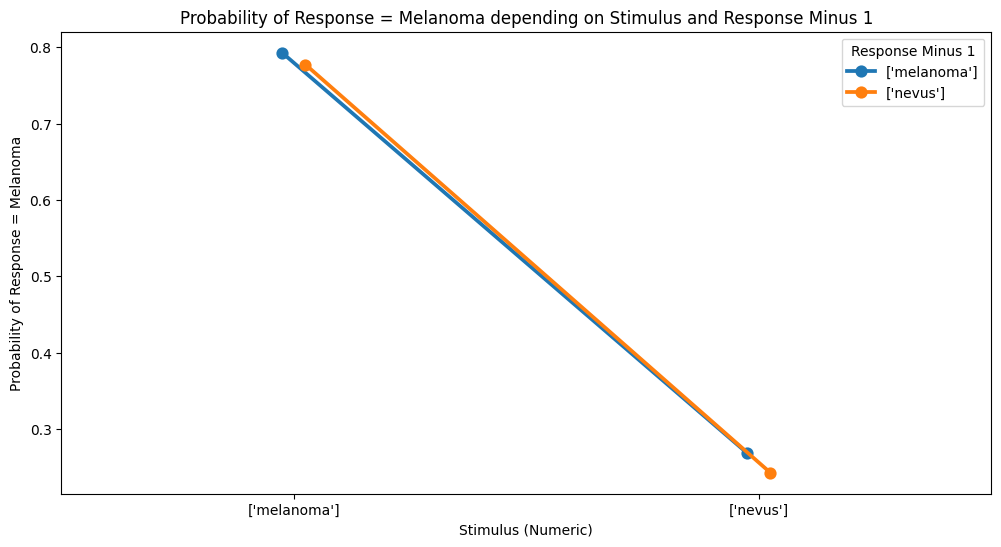

In [157]:
import seaborn as sns
from scipy import stats

# Compute probabilities of response = melanoma depending on stimulus and response_minus_1
grouped = df.groupby(['stimulus', 'response_minus_1']).response_numeric.mean().reset_index()
grouped.rename(columns={'response_numeric': 'prob_response_melanoma'}, inplace=True)

# Exclude rows where response_minus_1 is '["no_data"]'
filtered_df = df[df['response_minus_1'] != "['no_data']"]

# Group by user_id, stimulus, and response_minus_1
grouped = filtered_df.groupby(['stimulus', 'response_minus_1']).response_numeric.mean().reset_index()
grouped.rename(columns={'response_numeric': 'prob_response_melanoma'}, inplace=True)


# Plotting
plt.figure(figsize=(12, 6))

# Use seaborn for the visualization
sns.pointplot(data=grouped, x='stimulus', y='prob_response_melanoma', hue='response_minus_1', errorbar='sd', dodge=True, markers='o', capsize=.1)

# Adding labels and titles
plt.xlabel('Stimulus (Numeric)')
plt.ylabel('Probability of Response = Melanoma')
plt.title('Probability of Response = Melanoma depending on Stimulus and Response Minus 1')
plt.legend(title='Response Minus 1')

plt.show()

## Format for GLM-HMM

In [73]:
### Set the parameters of the GLM-HMM
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2        # input dimensions
N_iters = 10

In [66]:
inpts = []
choices = []
participants = df.user_id.unique()

# Assuming input_dim is defined elsewhere
input_dim = 2  # Adjust as necessary

for load_idx in participants:
    this_data = df.loc[df['user_id'] == load_idx].copy()
    
    # Print output
    print(f"Processing data for user_id: {load_idx}, number of trials: {len(this_data)}")
    
    num_trials_per_sess = len(this_data)

    new_inpts = np.ones((num_trials_per_sess, input_dim))

    # Get input format
    new_inpts[:, 0] = this_data['stimulus_numeric'].copy()
    new_inpts[:, 1] = this_data['response_minus_1_numeric'].copy()
    # If needed, uncomment and adjust the following lines:
    # new_inpts[:, 2] = this_data['previous_contrast'].copy()
    # new_inpts[:, 2] = np.ones(this_data.shape[0])

    inpts.append(new_inpts)

    new_choices = this_data['response_numeric'].copy()
    new_choices = np.atleast_2d(new_choices).T
    choices.append(new_choices)

Processing data for user_id: 19769, number of trials: 15489
Processing data for user_id: 6114, number of trials: 822
Processing data for user_id: 11839, number of trials: 8131
Processing data for user_id: 1196, number of trials: 33786
Processing data for user_id: 36844, number of trials: 13536
Processing data for user_id: 36920, number of trials: 1062
Processing data for user_id: 30639, number of trials: 1725
Processing data for user_id: 37464, number of trials: 312
Processing data for user_id: 11715, number of trials: 4409
Processing data for user_id: 23646, number of trials: 5321
Processing data for user_id: 36647, number of trials: 3222
Processing data for user_id: 37588, number of trials: 542
Processing data for user_id: 11697, number of trials: 5827
Processing data for user_id: 31969, number of trials: 558
Processing data for user_id: 23524, number of trials: 280
Processing data for user_id: 11568, number of trials: 7929
Processing data for user_id: 37592, number of trials: 130
Pr

## Fit at group-level in one-state GLM-HMM

In [75]:
### fit one state GLM-HMM at group level

num_states = 1
n_iter = 1

transition_alpha = 1
prior_sigma = 10

iter_array = np.full([n_iter, 2], np.nan)
for idx in range(n_iter):
    
    one_state_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, 
                    observations="input_driven_obs", 
                    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                    transitions="sticky", 
                    transition_kwargs=dict(alpha=transition_alpha, kappa=0))
    one_state_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)
    iter_array[idx,] = one_state_glmhmm.observations.params.reshape((1,2))
    print(iter_array[idx,])


[-1.16221308 -0.05459531]


In [79]:
os.makedirs(hmm_dir, exist_ok=True)

df_iter_array = pd.DataFrame(iter_array, columns=['stimulus', 'previous_response'])

if save_data:
    df_iter_array.to_csv(os.path.join(hmm_dir, 'one_level_HMM_params.csv'), index=False)


In [78]:
df_iter_array.to_csv(os.path.join(hmm_dir, 'one_level_HMM_params.csv'), index=False)
params_for_initalization = df_iter_array.mean().values
print(params_for_initalization)

[-1.16221308 -0.05459531]


# Fit multi-state GLM-HMMs at group-level and compare BIC

In [83]:
## compare models based on BIC
max_num_states =  2    # number of discrete states

N_iters = 100 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
# Make a GLM-HMM
prior_sigma = 10
transition_alpha = 1

BIC = []
for state_idx in range(max_num_states): 
    print(state_idx)
    compare_glmhmm = ssm.HMM(state_idx+1, obs_dim, input_dim, 
                    observations="input_driven_obs", 
                    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                    transitions="sticky", 
                    transition_kwargs=dict(alpha=transition_alpha, kappa=0))

    
    _ = compare_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = True)
    n_total_params = np.concatenate(compare_glmhmm.observations.params).size + np.concatenate(compare_glmhmm.transitions.params).size
    
    # Flatten choices and inpts to calculate log likelihood correctly
    flattened_choices = np.concatenate(choices)
    flattened_inpts = np.concatenate(inpts)

    new_BIC = np.log(np.size(flattened_choices))*n_total_params - 2*compare_glmhmm.log_likelihood(choices, inputs=inpts)
    
    if save_data:
        pd.DataFrame(np.append(new_BIC, np.concatenate(compare_glmhmm.observations.params))).to_csv(root_dir + 'HMM/Full_model_outcome_states_' + str(state_idx + 1) + '.csv', index = False)

    BIC = np.append(BIC, new_BIC) 
    print(compare_glmhmm.observations.params)

df_BIC = pd.DataFrame({'BIC': BIC, 'num_states': np.arange(max_num_states) + 1})


if save_data:
    df_BIC.to_csv(os.path.join(hmm_dir, 'BIC_across_levels.csv'), index=False)


0
[[[-1.16218225 -0.05458351]]]
1
[[[-0.8723362  -0.06952902]]

 [[-1.55538048 -0.03128489]]]


array([-12049.36852877])

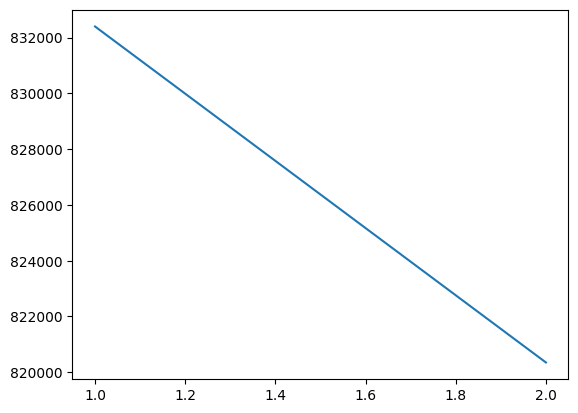

In [146]:
df_BIC = pd.read_csv(os.path.join(hmm_dir, 'BIC_across_levels.csv'))
plt.plot(df_BIC['num_states'], df_BIC['BIC'])
np.diff(df_BIC.BIC)

# Fit permuted multi-state GLM-HMMs at group-level and compare BIC

In [ ]:
# Permutation analysis
n_perm = 100
BIC_permuted = []

for perm_idx in range(n_perm):
    permuted_choices = []
    permuted_inpts = []
    
    for i in range(len(choices)):
        perm_indices = np.random.permutation(choices[i].shape[0])
        permuted_choices.append(choices[i][perm_indices])
        permuted_inpts.append(inpts[i][perm_indices])
    
    for state_idx in range(max_num_states):
        print(f"Permutation {perm_idx}, State {state_idx}")
        permuted_glmhmm = ssm.HMM(state_idx + 1, obs_dim, input_dim, 
                                  observations="input_driven_obs", 
                                  observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                                  transitions="sticky", 
                                  transition_kwargs=dict(alpha=transition_alpha, kappa=0))

        _ = permuted_glmhmm.fit(permuted_choices, inputs=permuted_inpts, method="em", num_iters=N_iters, initialize=True, tolerance=10**-4, verbose=False)

        n_total_params = np.concatenate(permuted_glmhmm.observations.params).size + np.concatenate(permuted_glmhmm.transitions.params).size

        # Compute log likelihood
        log_likelihood = permuted_glmhmm.log_likelihood(permuted_choices, inputs=permuted_inpts)

        # Compute BIC
        new_BIC = np.log(len(flattened_choices)) * n_total_params - 2 * log_likelihood
        BIC_permuted.append({'perm_idx': perm_idx, 'state_idx': state_idx + 1, 'BIC': new_BIC})

df_BIC_permuted = pd.DataFrame(BIC_permuted)
if save_data:
    df_BIC_permuted.to_csv(os.path.join(hmm_dir, 'BIC_permuted_across_levels.csv'), index=False)

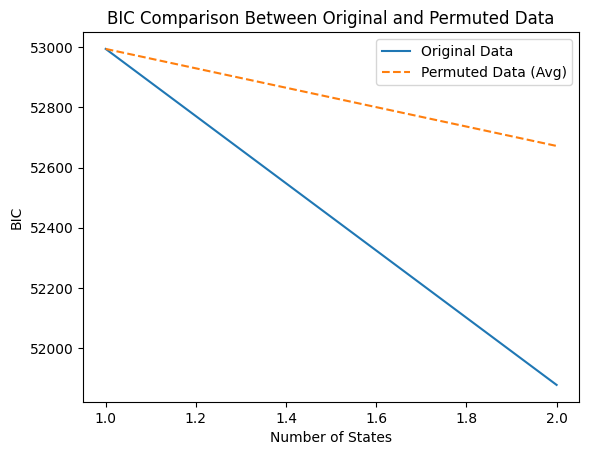

[-1117.01741079]


In [66]:
# Average BIC across permutations
df_BIC_permuted_avg = df_BIC_permuted.groupby('state_idx').agg({'BIC': 'mean'}).reset_index()

# Plotting
plt.plot(df_BIC['num_states'], df_BIC['BIC'], label='Original Data')
plt.plot(df_BIC_permuted_avg['state_idx'], df_BIC_permuted_avg['BIC'], label='Permuted Data (Avg)', linestyle='--')
plt.xlabel('Number of States')
plt.ylabel('BIC')
plt.legend()
plt.title('BIC Comparison Between Original and Permuted Data')
plt.show()

# Compute differences in BIC for original data
bic_diff = np.diff(df_BIC['BIC'])
print(bic_diff)

# Fit two-state GLM-HMMs at group-level to get initialization parameters

In [165]:
npr.seed(0)
# Set the parameters of the GLM-HMM
num_states =  2      # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2      # input dimensions

N_iters = 50 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
# Make a GLM-HMM

prior_sigma = 10
transition_alpha = 50

n_iter = 1
parameters_ext_int = np.full([n_iter, 8], np.nan)
for idx in range(n_iter):
    print(idx)
    glmhmm = ssm.HMM(num_states, obs_dim, input_dim, 
                        observations="input_driven_obs", 
                        observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                        transitions="sticky", 
                        transition_kwargs=dict(alpha=transition_alpha, kappa=0))
        
    #glmhmm.observations.params =  np.tile(params_for_initalization, (num_states,1)).reshape(num_states, 1, 3)
    _ = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)

    index_ext = np.argmax(np.concatenate(-glmhmm.observations.params)[:,0])
    index_int = np.argmin(np.concatenate(-glmhmm.observations.params)[:,0])
    parameters_ext_int[idx,] = np.concatenate((-glmhmm.observations.params[index_ext,:], -glmhmm.observations.params[index_int,:], glmhmm.transitions.params[0].reshape(1,4)), axis = 1)
    del(glmhmm)


0


In [95]:

df_two_state_init = pd.DataFrame(parameters_ext_int, columns = ['stimulus_ext', 'previous_response_ext',
                                                                'stimulus_int', 'previous_response_int',
                                                                 'AA', 'AB', 'BA', 'BB'])


In [96]:
if save_data:
    df_two_state_init.to_csv(os.path.join(hmm_dir, 'two_state_init_param.csv'), index=False)

In [97]:
df_two_state_init.mean()

stimulus_ext             1.560387
previous_response_ext    0.031120
stimulus_int             0.874033
previous_response_int    0.069546
AA                      -0.001080
AB                      -6.831084
BA                      -7.088759
BB                      -0.000835
dtype: float64

In [166]:
df_two_state_init = pd.read_csv(os.path.join(hmm_dir, 'two_state_init_param.csv'))
param_init_ext_int = df_two_state_init.mean().values

recovered_weights = -param_init_ext_int[0:4].reshape(2,1,2)
recovered_trans_mat = np.exp(param_init_ext_int[4:8].reshape(2,2))

Text(0.5, 1.0, 'Weight recovery')

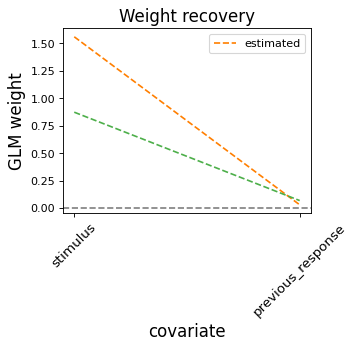

In [100]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8',  '#8B0000', '#000000']
for k in range(num_states):
    if k ==0:
        
        plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "estimated", linestyle = '--')
    else:
        plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'previous_response'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)

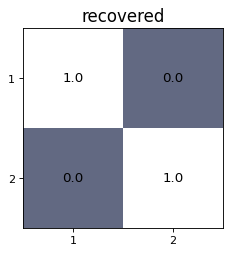

In [102]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)

## Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

In [103]:
# run average model
prior_sigma = 10

glmhmm = ssm.HMM(num_states, obs_dim, input_dim, 
                        observations="input_driven_obs", 
                        observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                        transitions="sticky", 
                        transition_kwargs=dict(alpha=transition_alpha, kappa=0))
        
glmhmm.init_state_distn.params = np.log([0.5, 0.5])
glmhmm.observations.params = -param_init_ext_int[0:4].reshape(2,1,2)
glmhmm.transitions.params = (param_init_ext_int[4:8].reshape(2,2),)

_ = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = False, tolerance=10**-4, verbose = False)
print(-glmhmm.observations.params)
index_ext = np.argmax(np.concatenate(-glmhmm.observations.params)[:,0])
index_int = np.argmin(np.concatenate(-glmhmm.observations.params)[:,0])

[[[1.55472952 0.03117567]]

 [[0.87249963 0.06964332]]]


In [104]:
# Get expected states:
posterior_probs = [glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(choices, inpts)]

Text(0, 0.5, 'p(state)')

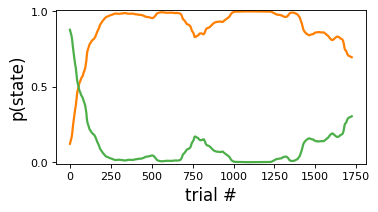

In [107]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 6 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][1:150000, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)

With these posterior state probabilities, we can assign trials to states and then plot the fractional occupancy of each state:

In [110]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

Text(0, 0.5, 'frac. occupancy')

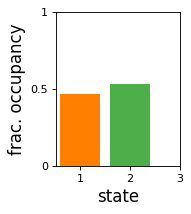

In [111]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

In [161]:
df = df.assign(Gl_Prob_State_ext = posterior_probs_concat[:,index_ext])
df = df.assign(Gl_Prob_State_int = posterior_probs_concat[:,index_int])

# Adding the Mode column based on the condition
df['Mode'] = df['Gl_Prob_State_ext'].apply(lambda x: 'external' if x >= 0.5 else 'internal')

# Detect mode switches by comparing current mode with the previous one
df['Mode_Switch'] = df['Mode'] != df['Mode'].shift()

# Only count switches within the same user
df['Mode_Switch'] = df['Mode_Switch'] & (df['user_id'] == df['user_id'].shift())

# Count the number of switches for each user
mode_switches = df.groupby('user_id')['Mode_Switch'].sum().reset_index()

if save_data:
    df.to_csv(os.path.join(hmm_dir, 'Full_HMM.csv'), index=False)

# Run participant-wise GLM-HMM

In [ ]:
participants = df.user_id.unique()

# Assuming input_dim is defined elsewhere
num_states =  2      # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2      # input dimensions

N_iters = 50 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
# Make a GLM-HMM

prior_sigma = 10
transition_alpha = 50


parameters_ext_int = np.full([len(participants), 8], np.nan)

for load_idx in participants:
    inpts = []
    choices = []
    
    this_data = df.loc[df['user_id'] == load_idx].copy()
    
    # Print output
    print(f"Processing data for user_id: {load_idx}, number of trials: {len(this_data)}")
    
    num_trials_per_sess = len(this_data)

    new_inpts = np.ones((num_trials_per_sess, input_dim))

    # Get input format
    new_inpts[:, 0] = this_data['stimulus_numeric'].copy()
    new_inpts[:, 1] = this_data['response_minus_1_numeric'].copy()
    # If needed, uncomment and adjust the following lines:
    # new_inpts[:, 2] = this_data['previous_contrast'].copy()
    # new_inpts[:, 2] = np.ones(this_data.shape[0])

    inpts.append(new_inpts)

    new_choices = this_data['response_numeric'].copy()
    new_choices = np.atleast_2d(new_choices).T
    choices.append(new_choices)

    glmhmm = ssm.HMM(num_states, obs_dim, input_dim, 
                        observations="input_driven_obs", 
                        observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                        transitions="sticky", 
                        transition_kwargs=dict(alpha=transition_alpha, kappa=0))
        
    #glmhmm.observations.params =  np.tile(params_for_initalization, (num_states,1)).reshape(num_states, 1, 3)
    _ = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)

    index_ext = np.argmax(np.concatenate(-glmhmm.observations.params)[:,0])
    index_int = np.argmin(np.concatenate(-glmhmm.observations.params)[:,0])
    parameters_ext_int[load_idx,] = np.concatenate((-glmhmm.observations.params[index_ext,:], -glmhmm.observations.params[index_int,:], glmhmm.transitions.params[0].reshape(1,4)), axis = 1)
    print(load_idx)
    del(glmhmm)


## Replot data depending on mode

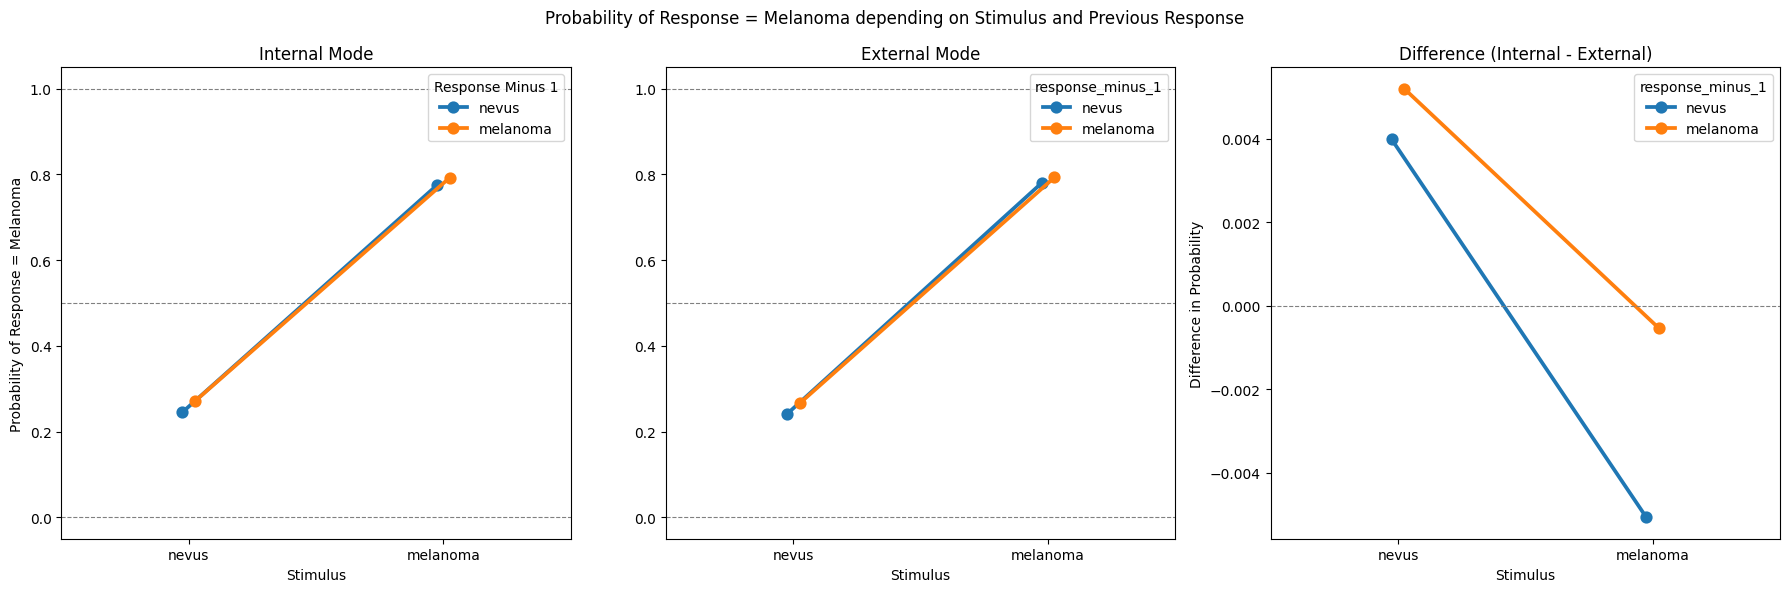

In [160]:
# Compute the difference
merged_df = pd.merge(grouped_internal, grouped_external, on=['stimulus', 'response_minus_1'], suffixes=('_internal', '_external'))
merged_df['prob_response_difference'] = merged_df['prob_response_melanoma_internal'] - merged_df['prob_response_melanoma_external']

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Add horizontal lines at 0, 0.5, and 1 for the first two subplots
for ax in axes[:2]:
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8)
    ax.axhline(y=1, color='gray', linestyle='--', linewidth=0.8)

# Define the order of categories
order = ['nevus', 'melanoma']

# Internal mode plot
sns.pointplot(data=merged_df, x='stimulus', y='prob_response_melanoma_internal', hue='response_minus_1', order=order, hue_order=order, dodge=True, markers='o', capsize=.1, ax=axes[0])
axes[0].set_title('Internal Mode')
axes[0].set_xlabel('Stimulus')
axes[0].set_ylabel('Probability of Response = Melanoma')

# External mode plot
sns.pointplot(data=merged_df, x='stimulus', y='prob_response_melanoma_external', hue='response_minus_1', order=order, hue_order=order, dodge=True, markers='o', capsize=.1, ax=axes[1])
axes[1].set_title('External Mode')
axes[1].set_xlabel('Stimulus')
axes[1].set_ylabel('')

# Difference plot
sns.pointplot(data=merged_df, x='stimulus', y='prob_response_difference', hue='response_minus_1', order=order, hue_order=order, dodge=True, markers='o', capsize=.1, ax=axes[2])
axes[2].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
axes[2].set_title('Difference (Internal - External)')
axes[2].set_xlabel('Stimulus')
axes[2].set_ylabel('Difference in Probability')

# Add a legend to the first subplot
axes[0].legend(title='Response Minus 1')

plt.suptitle('Probability of Response = Melanoma depending on Stimulus and Previous Response')
plt.tight_layout()
plt.show()